In [1]:
# Cell 1: Import necessary libraries
import pandas as pd
import numpy as np
import re
import string
import time
import os
import warnings
from collections import defaultdict
import torch
import torch.nn.functional as F
from Levenshtein import distance as levenshtein_distance
from Levenshtein import jaro_winkler, ratio as levenshtein_ratio
import textdistance
from fuzzywuzzy import fuzz
import jellyfish
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

try:
    from transformers import AutoTokenizer, AutoModel
    transformers_available = True
    print("Transformers library available for BERT embeddings")
except ImportError:
    transformers_available = False
    print("Warning: transformers library not available. Will use TF-IDF fallback.")

# Try to import pyahocorasick with fallback
try:
    import pyahocorasick
    aho_corasick_available = True
    print("pyahocorasick is available")
except ImportError:
    print("Warning: pyahocorasick not available. Using fallback implementation.")
    aho_corasick_available = False

# Suppress warnings
warnings.filterwarnings('ignore')

# Check for GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

print("All libraries imported successfully!")

Transformers library available for BERT embeddings
Using device: cpu
All libraries imported successfully!


In [3]:
# Cell 2: Enhanced BERT Embedder with MPNet Model

class EnhancedBERTEmbedder:
    """
    Enhanced BERT embedder using the more powerful MPNet model for better semantic understanding.
    Implements advanced pooling strategies, merchant category adaptation, and batching for efficiency.
    """
    
    def __init__(self, model_name='sentence-transformers/all-mpnet-base-v2', pooling_strategy='mean', device=None):
        """
        Initialize enhanced BERT embedder with specified pre-trained model and pooling strategy.
        
        Args:
            model_name (str): Name of the pre-trained BERT model to use
            pooling_strategy (str): Pooling strategy ('mean', 'cls', or 'max')
            device: Device to run the model on (cuda or cpu)
        """
        self.model_name = model_name
        self.pooling_strategy = pooling_strategy
        self.max_sequence_length = 512  # BERT's limit
        
        if device is None:
            self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        else:
            self.device = device
            
        self.initialized = False
        self.category_adapted = False  # Renamed from domain_adapted
        self.category_embeddings = {}  # Storage for category-specific embeddings
        
        # Initialize pre-trained model if transformers available
        if transformers_available:
            try:
                print(f"Loading enhanced BERT model '{model_name}'...")
                self.tokenizer = AutoTokenizer.from_pretrained(model_name)
                self.model = AutoModel.from_pretrained(model_name).to(self.device)
                self.model.eval()  # Set to evaluation mode
                self.initialized = True
                print(f"Enhanced BERT model loaded successfully on {self.device}")
            except Exception as e:
                print(f"Error initializing BERT model: {e}")
                self.initialized = False
        
        # Initialize TF-IDF fallback if BERT not available
        if not self.initialized:
            # Using character n-grams for better handling of typos and abbreviations
            self.tfidf_vectorizer = TfidfVectorizer(analyzer='char_wb', ngram_range=(2, 4))
            self.tfidf_fitted = False
            print("Using TF-IDF fallback for embeddings")
    
    def _mean_pooling(self, model_output, attention_mask):
        """
        Mean pooling - take average of all token embeddings
        """
        token_embeddings = model_output[0]  # First element contains all token embeddings
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
        return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)
    
    def _cls_pooling(self, model_output, attention_mask):
        """
        CLS pooling - use the [CLS] token embedding
        """
        return model_output[0][:, 0]
    
    def _max_pooling(self, model_output, attention_mask):
        """
        Max pooling - take max of all token embeddings
        """
        token_embeddings = model_output[0]
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
        token_embeddings[input_mask_expanded == 0] = -1e9  # Set padding tokens to large negative value
        return torch.max(token_embeddings, 1)[0]
    
    def _get_pooled_embeddings(self, model_output, attention_mask):
        """
        Apply the selected pooling strategy
        """
        if self.pooling_strategy == 'mean':
            return self._mean_pooling(model_output, attention_mask)
        elif self.pooling_strategy == 'cls':
            return self._cls_pooling(model_output, attention_mask)
        elif self.pooling_strategy == 'max':
            return self._max_pooling(model_output, attention_mask)
        else:
            # Default to mean pooling
            return self._mean_pooling(model_output, attention_mask)
    
    def fit(self, texts):
        """
        Fit the TF-IDF vectorizer on a corpus of texts (only needed for TF-IDF fallback)
        """
        if not self.initialized:
            # Fit TF-IDF vectorizer
            self.tfidf_vectorizer.fit(texts)
            self.tfidf_fitted = True
            print("TF-IDF vectorizer fitted on corpus")

    
    def encode(self, texts, batch_size=32, show_progress=False, merchant_category=None):
        """
        Encode texts into embeddings using the pre-trained model,
        optionally considering merchant category information
        
        Args:
            texts: List of texts or single text
            batch_size: Batch size for processing
            show_progress: Whether to show progress
            merchant_category: Optional merchant category to influence encoding
            
        Returns:
            numpy.ndarray: Embeddings for the texts
        """
        # Handle single text input
        if isinstance(texts, str):
            texts = [texts]
        
        # Return empty array for empty input
        if len(texts) == 0:
            return np.array([])
        
        # Use pre-trained BERT if available
        if self.initialized:
            # Process in batches
            all_embeddings = []
            
            for i in range(0, len(texts), batch_size):
                if show_progress and i % (batch_size * 10) == 0:
                    print(f"Processing batch {i//batch_size + 1}/{(len(texts)//batch_size) + 1}")
                
                batch_texts = texts[i:i+batch_size]
                
                # Tokenize
                encoded_input = self.tokenizer(
                    batch_texts, 
                    padding=True, 
                    truncation=True, 
                    max_length=self.max_sequence_length,
                    return_tensors='pt'
                ).to(self.device)
                
                # Compute token embeddings
                with torch.no_grad():
                    model_output = self.model(**encoded_input)
                    batch_embeddings = self._get_pooled_embeddings(model_output, encoded_input['attention_mask'])
                    all_embeddings.append(batch_embeddings.cpu().numpy())
            
            embeddings = np.vstack(all_embeddings)
            
            # Apply merchant category adaptation if available
            if self.category_adapted and merchant_category and merchant_category in self.category_embeddings:
                # Blend with category embedding (subtle influence)
                category_embedding = self.category_embeddings[merchant_category]
                alpha = 0.1  # Blend factor - subtle influence
                embeddings = (1 - alpha) * embeddings + alpha * category_embedding
                
                # Re-normalize
                embeddings = embeddings / np.linalg.norm(embeddings, axis=1, keepdims=True)
            
            return embeddings
        
        else:
            # Use TF-IDF fallback
            if not self.tfidf_fitted:
                self.fit(texts)
            
            return self.tfidf_vectorizer.transform(texts).toarray()
    
    def compute_similarity(self, text1, text2, merchant_category1=None, merchant_category2=None):
        """
        Compute cosine similarity between two texts using the pre-trained model,
        optionally considering merchant category information
        
        Args:
            text1: First text
            text2: Second text
            merchant_category1: Merchant category for first text
            merchant_category2: Merchant category for second text
            
        Returns:
            float: Cosine similarity score
        """
        # Get embeddings for both texts, considering merchant categories
        emb1 = self.encode(text1, merchant_category=merchant_category1)
        emb2 = self.encode(text2, merchant_category=merchant_category2)
        
        # Compute cosine similarity
        return np.sum(emb1 * emb2) / (np.linalg.norm(emb1) * np.linalg.norm(emb2) + 1e-8)

In [5]:
# Cell 3: Enhanced Merchant Matcher Core Class

class EnhancedMerchantMatcher:
    """
    Enhanced matcher with improved pattern recognition for merchant name matching.
    Uses multiple similarity algorithms and merchant category-specific patterns.
    """
    def __init__(self, bert_embedder=None):
        """
        Initialize with enhanced BERT embedder.
        
        Args:
            bert_embedder: Enhanced BERT embedder instance
        """
        # Initialize enhanced BERT embedder
        self.bert_embedder = bert_embedder
        if self.bert_embedder is None and transformers_available:
            self.bert_embedder = EnhancedBERTEmbedder()
        
        # Initialize TF-IDF vectorizer
        self.tfidf_vectorizer = TfidfVectorizer()
        
        # Initialize trie for approximate matching
        self.trie = None
        
        # Initialize Aho-Corasick automaton only if available
        if aho_corasick_available:
            self.automaton = pyahocorasick.Automaton()
        else:
            self.automaton = None
        
        # Define abbreviation dictionary - comprehensive industry knowledge 
        self.abbreviations = self._get_abbreviation_dictionary()
        
        # Merchant category-specific abbreviations 
        self.merchant_category_abbreviations = self._get_merchant_category_abbreviations()
        
        # Stop words to remove during preprocessing
        self.stopwords = self._get_stopwords()
        
        # Merchant category-specific stopwords 
        self.merchant_category_stopwords = self._get_merchant_category_stopwords()
        
        # Add base weights as a class attribute
        self.base_weights = {
            'jaro_winkler': 0.10,
            'damerau_levenshtein': 0.05,
            'tfidf_cosine': 0.05,
            'jaccard_bigram': 0.05,
            'soundex': 0.05,
            'token_sort_ratio': 0.10,
            'contains_ratio': 0.10,
            'fuzzy_levenshtein': 0.05,
            'trie_approximate': 0.10,
            'bert_similarity': 0.15,
            'aho_corasick': 0.05,
            'DBAName_formation': 0.15
        }
        
    
    def _get_abbreviation_dictionary(self):
        """Get comprehensive abbreviation dictionary"""
        return {
            # Banking & Financial Institutions
            'bofa': 'bank of america', 'b of a': 'bank of america',
            'boa': 'bank of america', 'bac': 'bank of america',
            'jpm': 'jpmorgan chase', 'jpm chase': 'jpmorgan chase',
            'wf': 'wells fargo', 'wfb': 'wells fargo bank',
            'citi': 'citibank', 'citi bank': 'citibank',
            'gs': 'goldman sachs', 'ms': 'morgan stanley',
            'db': 'deutsche bank', 'hsbc': 'hongkong and shanghai banking corporation',
            'amex': 'american express', 'usb': 'us bank', 'rbc': 'royal bank of canada',
            'pnc': 'pnc financial services', 'td': 'toronto dominion bank',
            'bny': 'bank of new york', 'bnyc': 'bank of new york mellon',
            'cba': 'commonwealth bank of australia', 'nab': 'national australia bank',
            'rba': 'reserve bank of australia', 'westpac': 'western pacific bank',
            
            # Fast Food & Restaurant Chains
            'mcd': 'mcdonalds', 'mcds': 'mcdonalds', 'md': 'mcdonalds',
            'bk': 'burger king', 'kfc': 'kentucky fried chicken',
            'sbux': 'starbucks', 'sb': 'starbucks',
            'tb': 'taco bell', 'wen': 'wendys',
            'dq': 'dairy queen', 'ph': 'pizza hut',
            'dnkn': 'dunkin donuts', 'cfa': 'chick fil a',
            'cmg': 'chipotle mexican grill', 'ihop': 'international house of pancakes',
            'tgi': 'tgi fridays', 'tgif': 'tgi fridays',
            
            # Tech Companies
            'msft': 'microsoft', 'aapl': 'apple', 'goog': 'google',
            'googl': 'google', 'amzn': 'amazon', 'fb': 'facebook',
            'meta': 'meta platforms', 'nflx': 'netflix', 'tsla': 'tesla',
            'ibm': 'international business machines', 'csco': 'cisco systems',
            'orcl': 'oracle', 'intc': 'intel', 'amd': 'advanced micro devices',
            'nvda': 'nvidia', 'adbe': 'adobe', 'crm': 'salesforce',
            
            # Automotive
            'tm': 'toyota motor', 'toyof': 'toyota', 'toyota': 'toyota corporation',
            'f': 'ford motor company', 'gm': 'general motors',
            'hmc': 'honda motor company', 'hndaf': 'honda',
            'nsany': 'nissan', 'bmwyy': 'bmw', 'vwagy': 'volkswagen',
            
            # Retail companies
            'wmt': 'walmart', 'tgt': 'target', 'cost': 'costco',
            'hd': 'home depot', 'low': 'lowes', 'bby': 'best buy',
            'ebay': 'ebay', 'dg': 'dollar general', 'dltr': 'dollar tree',
            
            # Government & Organizations
            'dhs': 'department of homeland security',
            'dod': 'department of defense', 'dos': 'department of state',
            'epa': 'environmental protection agency', 'fbi': 'federal bureau of investigation',
            'cia': 'central intelligence agency', 'irs': 'internal revenue service',
            'fda': 'food and drug administration', 'sec': 'securities and exchange commission',
            'usps': 'united states postal service', 'doi': 'department of interior',
            'fed': 'federal reserve', 'who': 'world health organization',
            'un': 'united nations', 'nato': 'north atlantic treaty organization',
            
            # Common abbreviations
            'j&j': 'johnson & johnson', 'jj': 'johnson johnson', 
            'jnj': 'johnson and johnson', '7-11': '7-eleven', 
            '711': '7-eleven', 'intl': 'international',
            'corp': 'corporation', 'inc': 'incorporated',
            
            # Address components
            'rd': 'road', 'st': 'street', 'ave': 'avenue', 
            'blvd': 'boulevard', 'ctr': 'center', 'ln': 'lane', 
            'dr': 'drive', 'pl': 'place', 'ct': 'court',
            'hwy': 'highway', 'pkwy': 'parkway', 'sq': 'square'
        }
    
    def _get_merchant_category_abbreviations(self):
        """Get merchant category-specific abbreviation dictionaries """
        return {
            'Medical': {
                'dr': 'doctor', 'hosp': 'hospital', 'med': 'medical',
                'clin': 'clinic', 'pharm': 'pharmacy', 'lab': 'laboratory',
                'dept': 'department', 'ctr': 'center', 'inst': 'institute',
                'er': 'emergency room', 'icu': 'intensive care unit',
                'ob': 'obstetrics', 'gyn': 'gynecology', 'peds': 'pediatrics',
                'ortho': 'orthopedics', 'onc': 'oncology', 'neuro': 'neurology'
            },
            'Government': {
                'govt': 'government', 'dept': 'department', 'admin': 'administration',
                'auth': 'authority', 'fed': 'federal', 'natl': 'national',
                'comm': 'commission', 'sec': 'secretary', 'org': 'organization',
                'div': 'division', 'bur': 'bureau', 'off': 'office',
                'min': 'ministry', 'reg': 'regional', 'dist': 'district',
                'cncl': 'council', 'cmte': 'committee', 'subcmte': 'subcommittee'
            },
            'Education': {
                'univ': 'university', 'coll': 'college', 'acad': 'academy',
                'elem': 'elementary', 'sch': 'school', 'inst': 'institute',
                'dept': 'department', 'lib': 'library', 'lab': 'laboratory',
                'fac': 'faculty', 'prof': 'professor', 'assoc': 'associate',
                'asst': 'assistant', 'adm': 'administration', 'stdnt': 'student',
                'grad': 'graduate', 'undergrad': 'undergraduate'
            },
            'Financial': {
                'fin': 'financial', 'svcs': 'services', 'mgmt': 'management',
                'assoc': 'associates', 'intl': 'international', 'grp': 'group',
                'corp': 'corporation', 'cap': 'capital', 'inv': 'investment',
                'asset': 'asset management', 'sec': 'securities', 'adv': 'advisors',
                'tr': 'trust', 'port': 'portfolio', 'acct': 'account',
                'bal': 'balance', 'stmt': 'statement', 'equ': 'equity'
            },
            'Restaurant': {
                'rest': 'restaurant', 'cafe': 'cafeteria', 'grill': 'grillery',
                'brew': 'brewery', 'bar': 'bar and grill', 'bbq': 'barbecue',
                'deli': 'delicatessen', 'stk': 'steakhouse', 'bf': 'breakfast',
                'din': 'dinner', 'chs': 'cheese', 'ckn': 'chicken'
            }
        }
    
    def _get_stopwords(self):
        """Get general stopwords for preprocessing"""
        return {
            'inc', 'llc', 'co', 'ltd', 'corp', 'plc', 'na', 'the', 
            'and', 'of', 'for', 'in', 'a', 'an', 'by', 'to', 'at',
            'corporation', 'incorporated', 'company', 'limited',
            'with', 'from', 'as', 'on', 'group', 'services'
        }
    
    def _get_merchant_category_stopwords(self):
        """Get merchant category-specific stopwords (renamed from _get_domain_stopwords)"""
        return {
            'Medical': {'center', 'healthcare', 'medical', 'health', 'care', 'services', 'clinic', 'hospital'},
            'Government': {'department', 'office', 'agency', 'bureau', 'division', 'authority', 'administration'},
            'Education': {'university', 'college', 'school', 'institute', 'academy', 'education', 'learning'},
            'Financial': {'financial', 'services', 'management', 'capital', 'investment', 'banking', 'advisor'},
            'Restaurant': {'restaurant', 'cafe', 'diner', 'eatery', 'grill', 'kitchen', 'bar', 'house'}
        }
    
    def enhanced_preprocessing(self, text, merchant_category=None):
        """
        Enhanced preprocessing with better handling of merchant-specific patterns
        
        Args:
            text (str): Text to preprocess
            merchant_category (str, optional): Merchant category for specialized processing
        
        Returns:
            str: Preprocessed text
        """
        if not isinstance(text, str):
            return ""
        
        # Convert to lowercase
        text = text.lower()
        
        # Better handling of punctuation - preserve periods in DBANames
        # and apostrophes in business names (e.g., McDonald's)
        text = re.sub(r'([^a-z0-9\'\.\&\-])', ' ', text)
        
        # Special handling for business name apostrophes
        text = re.sub(r'\'s\b', 's', text)  # Convert McDonald's to McDonalds
        
        # Expand common business suffixes
        business_suffixes = {
            r'\bco\b': 'company',
            r'\binc\b': '',  # Remove Inc entirely
            r'\bltd\b': 'limited',
            r'\bllc\b': '',  # Remove LLC entirely
            r'\bcorp\b': 'corporation',
            r'\bcorporation\b': '',  # Remove when processing full names for matching
            r'\blimited\b': '',      # Remove when processing full names for matching
            r'\bcompany\b': '',      # Remove when processing full names for matching
        }
        
        for suffix, replacement in business_suffixes.items():
            text = re.sub(suffix, replacement, text)
        
        # Replace abbreviations
        words = text.split()
        
        # Apply general abbreviation expansion
        words = [self.abbreviations.get(word, word) for word in words]
        
        # Apply merchant category-specific abbreviation expansion if merchant_category is provided
        if merchant_category and merchant_category in self.merchant_category_abbreviations:
            words = [self.merchant_category_abbreviations[merchant_category].get(word, word) for word in words]
        
        # Enhanced handling for McDonalds variations
        if any('mc' in word.lower() for word in words):
            words = ['mcdonalds' if word.lower() in ['mcd', 'mcds', 'mcdon'] else word for word in words]
        
        # Remove general stopwords
        words = [word for word in words if word not in self.stopwords]
        
        # Remove merchant category-specific stopwords if merchant_category is provided
        if merchant_category and merchant_category in self.merchant_category_stopwords:
            words = [word for word in words if word not in self.merchant_category_stopwords[merchant_category]]
        
        # Rejoin words and remove extra spaces
        text = ' '.join(words)
        text = re.sub(r'\s+', ' ', text).strip()
        
        return text
    
    def preprocess_pair(self, DBAName, DBA_Merchant_Category, RawTransactionName, RawTransaction_Merchant_Category):
        """Preprocess DBAName and RawTransactionName with their respective merchant categories"""
        DBAName_clean = self.enhanced_preprocessing(DBAName, DBA_Merchant_Category)
        RawTransactionName_clean = self.enhanced_preprocessing(RawTransactionName, RawTransaction_Merchant_Category)
        return DBAName_clean, RawTransactionName_clean

In [17]:
# Cell 4: Similarity Methods for Merchant Matcher

class EnhancedMerchantMatcherWithSimilarity(EnhancedMerchantMatcher):
    """Adding similarity methods to the EnhancedMerchantMatcher class"""
    
    def jaro_winkler_similarity(self, DBAName, DBA_Merchant_Category, RawTransactionName, RawTransaction_Merchant_Category):
        """
        Calculate Jaro-Winkler similarity with enhanced preprocessing
        
        Args:
            DBAName (str): The DBAName to match
            DBA_Merchant_Category (str): Merchant category for the DBAName
            RawTransactionName (str): The full name to match against
            RawTransaction_Merchant_Category (str, optional): Merchant category for the RawTransactionName
            
            
        Returns:
            float: Jaro-Winkler similarity score between 0 and 1
        """
        DBAName_clean, RawTransactionName_clean = self.preprocess_pair(DBAName, DBA_Merchant_Category, RawTransactionName, RawTransaction_Merchant_Category)
        # Check if strings are empty
        if not DBAName_clean or not RawTransactionName_clean:
            return 0
        return jaro_winkler(DBAName_clean, RawTransactionName_clean)
    
    def damerau_levenshtein_similarity(self, DBAName, DBA_Merchant_Category, RawTransactionName, RawTransaction_Merchant_Category):
        """
        Calculate Damerau-Levenshtein similarity, better for handling transpositions
        
        Args:
            DBAName (str): The DBAName to match
        DBA_Merchant_Category (str): Merchant category for the DBAName
        RawTransactionName (str): The full name to match against
        RawTransaction_Merchant_Category (str, optional): Merchant category for the RawTransactionName
            
        Returns:
            float: Damerau-Levenshtein similarity score between 0 and 1
        """
        DBAName_clean, RawTransactionName_clean = self.preprocess_pair(DBAName, DBA_Merchant_Category, RawTransactionName, RawTransaction_Merchant_Category)
        # Check if strings are empty
        if not DBAName_clean or not RawTransactionName_clean:
            return 0
        
        # Calculate Damerau-Levenshtein distance
        max_len = max(len(DBAName_clean), len(RawTransactionName_clean))
        if max_len == 0:
            return 0
        
        distance = textdistance.damerau_levenshtein.distance(DBAName_clean, RawTransactionName_clean)
        similarity = 1 - (distance / max_len)
        return max(0, similarity)  # Ensure non-negative
    
    def tfidf_cosine_similarity(self, DBAName, DBA_Merchant_Category, RawTransactionName, RawTransaction_Merchant_Category):
        """
        Calculate TF-IDF Cosine similarity for keyword matching
        
        Args:
            DBAName (str): The DBAName to match
        DBA_Merchant_Category (str): Merchant category for the DBAName
        RawTransactionName (str): The full name to match against
        RawTransaction_Merchant_Category (str, optional): Merchant category for the RawTransactionName
            
        Returns:
            float: TF-IDF cosine similarity score between 0 and 1
        """
        DBAName_clean, RawTransactionName_clean = self.preprocess_pair(DBAName, DBA_Merchant_Category, RawTransactionName, RawTransaction_Merchant_Category)
        # Check if strings are empty
        if not DBAName_clean or not RawTransactionName_clean:
            return 0
        
        # Fit and transform with TF-IDF
        try:
            tfidf_matrix = self.tfidf_vectorizer.fit_transform([DBAName_clean, RawTransactionName_clean])
            similarity = cosine_similarity(tfidf_matrix[0:1], tfidf_matrix[1:2])[0][0]
            return float(max(0, similarity))  # Ensure non-negative
        except:
            return 0
    
    def jaccard_bigram_similarity(self, DBAName, DBA_Merchant_Category, RawTransactionName, RawTransaction_Merchant_Category):
        """
        Calculate Jaccard Bigram similarity for character overlaps
        
        Args:
            DBAName (str): The DBAName to match
        DBA_Merchant_Category (str): Merchant category for the DBAName
        RawTransactionName (str): The full name to match against
        RawTransaction_Merchant_Category (str, optional): Merchant category for the RawTransactionName
            
        Returns:
            float: Jaccard bigram similarity score between 0 and 1
        """
        DBAName_clean, RawTransactionName_clean = self.preprocess_pair(DBAName, DBA_Merchant_Category, RawTransactionName, RawTransaction_Merchant_Category)
        # Check if strings are empty
        if not DBAName_clean or not RawTransactionName_clean:
            return 0
        
        # Create bigrams
        def get_bigrams(text):
            return [text[i:i+2] for i in range(len(text)-1)]
        
        DBAName_bigrams = set(get_bigrams(DBAName_clean))
        RawTransactionName_bigrams = set(get_bigrams(RawTransactionName_clean))
        
        # Calculate Jaccard similarity
        union_size = len(DBAName_bigrams.union(RawTransactionName_bigrams))
        if union_size == 0:
            return 0
        
        intersection_size = len(DBAName_bigrams.intersection(RawTransactionName_bigrams))
        return intersection_size / union_size
    
    def soundex_similarity(self, DBAName, DBA_Merchant_Category, RawTransactionName, RawTransaction_Merchant_Category):
        """
        Calculate phonetic similarity using Soundex algorithm.
        Especially useful for similar-sounding business names.
        
        Args:
            DBAName (str): The DBAName to match
        DBA_Merchant_Category (str): Merchant category for the DBAName
        RawTransactionName (str): The full name to match against
        RawTransaction_Merchant_Category (str, optional): Merchant category for the RawTransactionName
            
        Returns:
            float: Phonetic similarity score between 0 and 1
        """
        DBAName_clean, RawTransactionName_clean = self.preprocess_pair(DBAName, DBA_Merchant_Category, RawTransactionName, RawTransaction_Merchant_Category)
        # If either string is empty, return 0
        if not DBAName_clean or not RawTransactionName_clean:
            return 0.0
        
        # Get the soundex codes for both strings
        try:
            # For multi-word strings, get soundex for each word
            DBAName_words = DBAName_clean.split()
            RawTransactionName_words = RawTransactionName_clean.split()
            
            # Get soundex codes for each word
            DBAName_codes = [jellyfish.soundex(word) for word in DBAName_words if len(word) > 1]
            RawTransactionName_codes = [jellyfish.soundex(word) for word in RawTransactionName_words if len(word) > 1]
            
            # Calculate matches between codes
            matches = 0
            total = max(len(DBAName_codes), len(RawTransactionName_codes))
            
            if total == 0:
                return 0.0
            
            # Count matched codes
            for code in DBAName_codes:
                if code in RawTransactionName_codes:
                    matches += 1
                    # Remove the matched code to avoid double counting
                    RawTransactionName_codes.remove(code)
            
            return matches / total
        except:
            # Fallback if there's an error with the soundex calculation
            return 0.0
    
    def token_sort_ratio_similarity(self, DBAName, DBA_Merchant_Category, RawTransactionName, RawTransaction_Merchant_Category):
        """
        Calculate Token Sort Ratio using fuzzywuzzy.
        Handles word order differences well.
        
        Args:
            DBAName (str): The DBAName to match
        DBA_Merchant_Category (str): Merchant category for the DBAName
        RawTransactionName (str): The full name to match against
        RawTransaction_Merchant_Category (str, optional): Merchant category for the RawTransactionName
            
        Returns:
            float: Token sort ratio similarity score between 0 and 1
        """
        DBAName_clean, RawTransactionName_clean = self.preprocess_pair(DBAName, DBA_Merchant_Category, RawTransactionName, RawTransaction_Merchant_Category)
        # Check if strings are empty
        if not DBAName_clean or not RawTransactionName_clean:
            return 0
        
        # Calculate Token Sort Ratio
        ratio = fuzz.token_sort_ratio(DBAName, RawTransactionName) / 100
        return ratio
    
    def contains_ratio_similarity(self, DBAName, DBA_Merchant_Category, RawTransactionName, RawTransaction_Merchant_Category):
        """
        Check if DBAName is contained in full name or vice versa
        
        Args:
            DBAName (str): The DBAName to match
        DBA_Merchant_Category (str): Merchant category for the DBAName
        RawTransactionName (str): The full name to match against
        RawTransaction_Merchant_Category (str, optional): Merchant category for the RawTransactionName
            
        Returns:
            float: Containment similarity score between 0 and 1
        """
        DBAName_clean, RawTransactionName_clean = self.preprocess_pair(DBAName, DBA_Merchant_Category, RawTransactionName, RawTransaction_Merchant_Category)
        # Check if strings are empty
        if not DBAName_clean or not RawTransactionName_clean:
            return 0
        
        # Check if DBAName is contained in full name
        if DBAName_clean in RawTransactionName_clean:
            return 1
        
        # Check if full name is contained in DBAName
        if RawTransactionName_clean in DBAName_clean:
            return 0.9
        
        # Check for partial containment
        DBAName_chars = list(DBAName_clean)
        RawTransactionName_chars = list(RawTransactionName_clean)
        
        matches = 0
        for char in DBAName_chars:
            if char in RawTransactionName_chars:
                matches += 1
                RawTransactionName_chars.remove(char)  # Remove matched char
        
        return matches / len(DBAName_chars) if len(DBAName_chars) > 0 else 0
    
    def fuzzy_levenshtein_similarity(self, DBAName, DBA_Merchant_Category, RawTransactionName, RawTransaction_Merchant_Category):
        """
        Calculate fuzzy Levenshtein ratio for typo tolerance
        
        Args:
            DBAName (str): The DBAName to match
        DBA_Merchant_Category (str): Merchant category for the DBAName
        RawTransactionName (str): The full name to match against
        RawTransaction_Merchant_Category (str, optional): Merchant category for the RawTransactionName
            
        Returns:
            float: Fuzzy Levenshtein similarity score between 0 and 1
        """
        DBAName_clean, RawTransactionName_clean = self.preprocess_pair(DBAName, DBA_Merchant_Category, RawTransactionName, RawTransaction_Merchant_Category)
        # Check if strings are empty
        if not DBAName_clean or not RawTransactionName_clean:
            return 0
        
        # Calculate Levenshtein ratio (which is already normalized)
        similarity = levenshtein_ratio(DBAName_clean, RawTransactionName_clean)
        return float(similarity)
    def trie_approximate_similarity(self, DBAName, DBA_Merchant_Category, RawTransactionName, RawTransaction_Merchant_Category):
        """
        Use approximate matching for DBAName formation detection
        
        Args:
            DBAName (str): The DBAName to match
        DBA_Merchant_Category (str): Merchant category for the DBAName
        RawTransactionName (str): The full name to match against
        RawTransaction_Merchant_Category (str, optional): Merchant category for the RawTransactionName
            
        Returns:
            float: Trie approximate similarity score between 0 and 1
        """
        DBAName_clean, RawTransactionName_clean = self.preprocess_pair(DBAName, DBA_Merchant_Category, RawTransactionName, RawTransaction_Merchant_Category)
        # Check if strings are empty
        if not DBAName_clean or not RawTransactionName_clean:
            return 0
        
        # Extract first letters from each word in full name
        words = RawTransactionName_clean.split()
        if not words:
            return 0
        
        first_letters = ''.join([word[0] for word in words if word])
        
        # Check if DBAName matches first letters
        if DBAName_clean.lower() == first_letters.lower():
            return 1
        
        # Calculate similarity for approximate matching
        max_len = max(len(DBAName_clean), len(first_letters))
        if max_len == 0:
            return 0
        
        distance = levenshtein_distance(DBAName_clean.lower(), first_letters.lower())
        similarity = 1 - (distance / max_len)
        return max(0, similarity)
    
    def aho_corasick_similarity(self, DBAName, DBA_Merchant_Category, RawTransactionName, RawTransaction_Merchant_Category):
        """
        Use Aho-Corasick algorithm for pattern matching
        
        Args:
            DBAName (str): The DBAName to match
        DBA_Merchant_Category (str): Merchant category for the DBAName
        RawTransactionName (str): The full name to match against
        RawTransaction_Merchant_Category (str, optional): Merchant category for the RawTransactionName
            
        Returns:
            float: Aho-Corasick similarity score between 0 and 1
        """
        DBAName_clean, RawTransactionName_clean = self.preprocess_pair(DBAName, DBA_Merchant_Category, RawTransactionName, RawTransaction_Merchant_Category)
        # Check if strings are empty
        if not DBAName_clean or not RawTransactionName_clean:
            return 0
        
        if not aho_corasick_available:
            # Fallback implementation when pyahocorasick is not available
            matches = 0
            remaining_text = RawTransactionName_clean
            for c in DBAName_clean:
                if c in remaining_text:
                    matches += 1
                    # Remove matched character to prevent duplicate counting
                    idx = remaining_text.find(c)
                    remaining_text = remaining_text[:idx] + remaining_text[idx+1:]
            
            return min(1.0, matches / len(DBAName_clean)) if len(DBAName_clean) > 0 else 0
        
        # Build automaton
        automaton = pyahocorasick.Automaton()
        for i, c in enumerate(DBAName_clean):
            automaton.add_word(c, (i, c))
        automaton.make_automaton()
        
        # Find matches
        matches = 0
        for _, (_, c) in automaton.iter(RawTransactionName_clean):
            matches += 1
        
        # Calculate score
        if len(DBAName_clean) == 0:
            return 0
        
        return min(1.0, matches / len(DBAName_clean))
    
    def bert_similarity(self, DBAName, DBA_Merchant_Category, RawTransactionName, RawTransaction_Merchant_Category):
        """
        Calculate semantic similarity using BERT embeddings
        
        Args:
            DBAName (str): The DBAName to match
        DBA_Merchant_Category (str): Merchant category for the DBAName
        RawTransactionName (str): The full name to match against
        RawTransaction_Merchant_Category (str, optional): Merchant category for the RawTransactionName
            
        Returns:
            float: BERT similarity score between 0 and 1
        """
        # If BERT embedder is not initialized, return 0
        if self.bert_embedder is None:
            return 0
        
        DBAName_clean, RawTransactionName_clean = self.preprocess_pair(DBAName, DBA_Merchant_Category, RawTransactionName, RawTransaction_Merchant_Category)
        
        # Check if strings are empty
        if not DBAName_clean or not RawTransactionName_clean:
            return 0
        
        try:
            # Get embeddings from pre-trained model
            emb1 = self.bert_embedder.encode(DBAName_clean)
            emb2 = self.bert_embedder.encode(RawTransactionName_clean)
            
            # Calculate cosine similarity
            dot_product = np.sum(emb1 * emb2)
            norm1 = np.linalg.norm(emb1)
            norm2 = np.linalg.norm(emb2)
            
            similarity = dot_product / (norm1 * norm2 + 1e-8)
            return float(similarity)
        except Exception as e:
            print(f"Error in BERT similarity calculation: {e}")
            return 0
    
    def DBAName_formation_score(self, DBAName, DBA_Merchant_Category, RawTransactionName, RawTransaction_Merchant_Category):
        """
        Calculate how well the DBAName is formed from the full name
        
        Args:
            DBAName (str): The DBAName to match
        DBA_Merchant_Category (str): Merchant category for the DBAName
        RawTransactionName (str): The full name to match against
        RawTransaction_Merchant_Category (str, optional): Merchant category for the RawTransactionName
            
        Returns:
            float: DBAName formation score between 0 and 1
        """
        DBAName_clean, RawTransactionName_clean = self.preprocess_pair(DBAName, DBA_Merchant_Category, RawTransactionName, RawTransaction_Merchant_Category)
        # Check if strings are empty
        if not DBAName_clean or not RawTransactionName_clean:
            return 0
        
        # Extract first letters from each word in full name
        words = RawTransactionName_clean.split()
        if not words:
            return 0
        
        # Standard DBAName formation - first letter of each word
        first_letters = ''.join([word[0] for word in words if word])
        
        # If exact match, return 1
        if DBAName_clean.lower() == first_letters.lower():
            return 1
        
        # Check partial match
        DBAName_chars = list(DBAName_clean.lower())
        first_letters_chars = list(first_letters.lower())
        
        matches = 0
        for char in DBAName_chars:
            if char in first_letters_chars:
                matches += 1
                first_letters_chars.remove(char)  # Remove matched char
        
        if len(DBAName_chars) == 0:
            return 0
        
        # Calculate partial match score
        return matches / len(DBAName_chars)
    
    def enhanced_DBAName_formation_score(self, DBAName, DBA_Merchant_Category, RawTransactionName, RawTransaction_Merchant_Category):
        """
        Enhanced DBAName formation score with special handling for common patterns
        particularly optimized for business names with prefixes like "Mc".
        
        Args:
            DBAName (str): The DBAName to match
        DBA_Merchant_Category (str): Merchant category for the DBAName
        RawTransactionName (str): The full name to match against
        RawTransaction_Merchant_Category (str, optional): Merchant category for the RawTransactionName
            
        Returns:
            float: Enhanced DBAName formation score between 0 and 1
        """
        DBAName_clean, RawTransactionName_clean = self.preprocess_pair(DBAName, DBA_Merchant_Category, RawTransactionName, RawTransaction_Merchant_Category)
        
        # Basic cleanup
        DBAName = DBAName_clean.lower()
        RawTransactionName = RawTransactionName_clean.lower()

        
        # Standard DBAName formation - first letter of each word
        words = RawTransactionName.split()
        if not words:
            return 0
        
        # Get first letters
        first_letters = ''.join([word[0] for word in words if word])
        
        # If exact match, return high score
        if DBAName == first_letters:
            return 1.0
        
        # Check for consonant-based DBAName (common in business DBANames)
        consonants = ''.join([c for c in RawTransactionName if c not in 'aeiou' and c.isalpha()])
        consonant_match = 0.0
        if len(DBAName) <= len(consonants):
            # Check for sequential consonant match
            DBAName_position = 0
            for i, c in enumerate(consonants):
                if DBAName_position < len(DBAName) and c == DBAName[DBAName_position]:
                    DBAName_position += 1
            
            consonant_sequential_match = DBAName_position / len(DBAName) if len(DBAName) > 0 else 0
            
            # Check for any consonant match
            matches = 0
            consonants_copy = consonants
            for char in DBAName:
                if char in consonants_copy:
                    matches += 1
                    consonants_copy = consonants_copy.replace(char, '', 1)
            
            consonant_any_match = matches / len(DBAName) if len(DBAName) > 0 else 0
            
            # Take the better score
            consonant_match = max(consonant_sequential_match, consonant_any_match)
            
            # Give higher scores for strong consonant matches
            if consonant_match > 0.7:
                return max(0.85, consonant_match)
        
        # Calculate ordered match score
        ordered_match = 0
        last_found_index = -1
        RawTransactionName_chars = list(RawTransactionName)
        
        for char in DBAName:
            found = False
            for i in range(last_found_index + 1, len(RawTransactionName_chars)):
                if char == RawTransactionName_chars[i]:
                    ordered_match += 1
                    last_found_index = i
                    found = True
                    break
            
            # If we couldn't find the character in order, try looking anywhere
            if not found:
                for i in range(len(RawTransactionName_chars)):
                    if i != last_found_index and char == RawTransactionName_chars[i]:
                        ordered_match += 0.5  # Half credit for out-of-order match
                        RawTransactionName_chars[i] = '_'  # Mark as used
                        break
        
        ordered_match_score = ordered_match / len(DBAName) if len(DBAName) > 0 else 0
        
        # Return the best score from different matching strategies
        return max(
            ordered_match_score * 0.9,  # Ordered match is good but not perfect
            consonant_match * 0.9,      # Consonant match is also valuable
            0.4                         # Minimum score to prevent too low values
        )
    
    def detect_complex_business_patterns(self, DBAName, DBA_Merchant_Category, RawTransactionName, RawTransaction_Merchant_Category):
        """
        Detect complex business name patterns that might be missed by basic algorithms
        
        Args:
            DBAName (str): The DBAName to match
        DBA_Merchant_Category (str): Merchant category for the DBAName
        RawTransactionName (str): The full name to match against
        RawTransaction_Merchant_Category (str, optional): Merchant category for the RawTransactionName
            
        Returns:
            dict: Dictionary of detected patterns with confidence scores
        """
        DBAName_clean, RawTransactionName_clean = self.preprocess_pair(DBAName, DBA_Merchant_Category, RawTransactionName, RawTransaction_Merchant_Category)
        DBAName = DBAName_clean.lower()
        RawTransactionName = RawTransactionName_clean.lower()
        
        patterns = {}
        
        # Government agency pattern (Dept of X <-> X Department)
        agency_terms = ['department', 'dept', 'ministry', 'office', 'bureau', 'administration', 'agency']
        has_agency_DBAName = any(term in DBAName for term in agency_terms)
        has_agency_full = any(term in RawTransactionName for term in agency_terms)
        
        if has_agency_DBAName or has_agency_full:
            # Check for inverted department structure pattern (common in government)
            # e.g., "Department of Treasury" vs "Treasury Department"
            words_DBAName = DBAName.split()
            words_full = RawTransactionName.split()
            
            # Find agency term positions
            agency_pos_a = -1
            agency_pos_f = -1
            
            for term in agency_terms:
                if agency_pos_a == -1 and any(term in word for word in words_DBAName):
                    agency_pos_a = next((i for i, word in enumerate(words_DBAName) if term in word), -1)
                if agency_pos_f == -1 and any(term in word for word in words_full):
                    agency_pos_f = next((i for i, word in enumerate(words_full) if term in word), -1)
                    
            if agency_pos_a != -1 and agency_pos_f != -1:
                # One at beginning, one at end (inverted structure)
                if (agency_pos_a == 0 and agency_pos_f == len(words_full) - 1) or \
                   (agency_pos_f == 0 and agency_pos_a == len(words_DBAName) - 1):
                    patterns['inverted_agency_structure'] = 1.0
                else:
                    patterns['similar_agency_structure'] = 0.7
        
        # Financial institution pattern
        bank_terms = ['bank', 'credit union', 'financial', 'savings', 'investment', 'trust']
        has_bank_DBAName = any(term in DBAName for term in bank_terms)
        has_bank_full = any(term in RawTransactionName for term in bank_terms)
        
        if has_bank_DBAName or has_bank_full:
            # Check for Bank of X vs X Bank pattern
            if ('bank of' in DBAName and 'bank' in RawTransactionName and 'of' not in RawTransactionName) or \
               ('bank of' in RawTransactionName and 'bank' in DBAName and 'of' not in DBAName):
                patterns['bank_name_inversion'] = 1.0
        
        # Abbreviation with ampersand pattern
        if '&' in RawTransactionName or 'and' in RawTransactionName:
            # Check if DBAName contains first letters of parts around ampersand
            parts = re.split(r'\s+&\s+|\s+and\s+', RawTransactionName)
            if len(parts) >= 2:
                first_letters = ''.join(part[0] for part in parts if part)
                if DBAName == first_letters:
                    patterns['ampersand_DBAName'] = 1.0
                elif all(letter in DBAName for letter in first_letters):
                    patterns['partial_ampersand_DBAName'] = 0.8
        
        # Multi-word business name with DBAName
        words_full = [w for w in RawTransactionName.split() if len(w) > 3]  # Only consider significant words
        if len(words_full) >= 3 and len(DBAName) >= 2:
            # Check if DBAName consists of first letters of significant words
            first_letters = ''.join(word[0] for word in words_full)
            if DBAName in first_letters:
                patterns['multiword_business_DBAName'] = 0.9
        
        # Regional/branch variation of business
        location_prefixes = ['north', 'south', 'east', 'west', 'central', 'metro', 'city', 
                            'downtown', 'regional', 'national', 'global', 'local']
        
        has_location_a = any(prefix in DBAName.split() for prefix in location_prefixes)
        has_location_f = any(prefix in RawTransactionName.split() for prefix in location_prefixes)
        
        if has_location_a != has_location_f:  # One has location, other doesn't
            # Remove location terms and compare the rest
            a_words = [w for w in DBAName.split() if w not in location_prefixes]
            f_words = [w for w in RawTransactionName.split() if w not in location_prefixes]
            
            # If remaining content is similar
            a_text = ' '.join(a_words)
            f_text = ' '.join(f_words)
            
            if a_text in f_text or f_text in a_text:
                patterns['regional_branch_variation'] = 1.0
            elif len(a_text) > 3 and len(f_text) > 3 and (a_text[:3] == f_text[:3]):
                patterns['potential_branch_variation'] = 0.7
        
        return patterns
    
    def get_all_similarity_scores(self, DBAName, DBA_Merchant_Category, RawTransactionName, RawTransaction_Merchant_Category):
        """
        Calculate all similarity scores at once for efficiency
        
        Args:
            DBAName (str): The DBAName to match
        DBA_Merchant_Category (str): Merchant category for the DBAName
        RawTransactionName (str): The full name to match against
        RawTransaction_Merchant_Category (str, optional): Merchant category for the RawTransactionName
            
        Returns:
            dict: Dictionary of algorithm name to score
        """
        # Return empty dictionary if either DBAName or RawTransactionName is None
        if DBAName is None or RawTransactionName is None:
            return {}
        
        # Calculate all similarity scores
        scores = {
            'jaro_winkler': self.jaro_winkler_similarity(DBAName, DBA_Merchant_Category, RawTransactionName, RawTransaction_Merchant_Category),
            'damerau_levenshtein': self.damerau_levenshtein_similarity(DBAName, DBA_Merchant_Category, RawTransactionName, RawTransaction_Merchant_Category),
            'tfidf_cosine': self.tfidf_cosine_similarity(DBAName, DBA_Merchant_Category, RawTransactionName, RawTransaction_Merchant_Category),
            'jaccard_bigram': self.jaccard_bigram_similarity(DBAName, DBA_Merchant_Category, RawTransactionName, RawTransaction_Merchant_Category),
            'soundex': self.soundex_similarity(DBAName, DBA_Merchant_Category, RawTransactionName, RawTransaction_Merchant_Category),
            'token_sort_ratio': self.token_sort_ratio_similarity(DBAName, DBA_Merchant_Category, RawTransactionName, RawTransaction_Merchant_Category),
            'contains_ratio': self.contains_ratio_similarity(DBAName, DBA_Merchant_Category, RawTransactionName, RawTransaction_Merchant_Category),
            'fuzzy_levenshtein': self.fuzzy_levenshtein_similarity(DBAName, DBA_Merchant_Category, RawTransactionName, RawTransaction_Merchant_Category),
            'trie_approximate': self.trie_approximate_similarity(DBAName, DBA_Merchant_Category, RawTransactionName, RawTransaction_Merchant_Category),
            'aho_corasick': self.aho_corasick_similarity(DBAName, DBA_Merchant_Category, RawTransactionName, RawTransaction_Merchant_Category),
            'DBAName_formation': self.DBAName_formation_score(DBAName, DBA_Merchant_Category, RawTransactionName, RawTransaction_Merchant_Category),
            'enhanced_DBAName_formation': self.enhanced_DBAName_formation_score(DBAName, DBA_Merchant_Category, RawTransactionName, RawTransaction_Merchant_Category)
        }
        
        # Add BERT similarity if available
        if self.bert_embedder is not None:
            scores['bert_similarity'] = self.bert_similarity(DBAName, DBA_Merchant_Category, RawTransactionName, RawTransaction_Merchant_Category)
        
        # Add pattern detection scores
        pattern_results = self.detect_complex_business_patterns(DBAName, DBA_Merchant_Category, RawTransactionName, RawTransaction_Merchant_Category)
        for pattern, score in pattern_results.items():
            scores[f'pattern_{pattern}'] = score
        
        return scores

    def get_dynamic_weights(self, DBAName, DBA_Merchant_Category, RawTransactionName, RawTransaction_Merchant_Category):
        """
        Get dynamically adjusted weights based on merchant name and category characteristics
        
        Args:
            DBAName (str): The DBAName or short name
            DBA_Merchant_Category (str): Category for the DBA
            RawTransactionName (str): The full merchant name
            RawTransaction_Merchant_Category (str, optional): Category for the raw transaction
                
        Returns:
            dict: Dictionary of dynamically adjusted algorithm weights
        """
        # Start with base weights defined in the class
        weights = self.base_weights.copy()
        
        # Adjust weights based on name characteristics
        DBAName_len = len(DBAName) if isinstance(DBAName, str) else 0
        RawTransactionName_len = len(RawTransactionName) if isinstance(RawTransactionName, str) else 0
        
        # Define primary_category based on DBA_Merchant_Category (THIS IS THE FIX)
        primary_category = DBA_Merchant_Category if DBA_Merchant_Category is not None else "Unknown"
        
        # For very short DBANames (2-3 chars), boost DBAName formation importance
        if 2 <= DBAName_len <= 3:
            weights['DBAName_formation'] = 0.25
            weights['enhanced_DBAName_formation'] = 0.20
            weights['bert_similarity'] = 0.15
            weights['contains_ratio'] = 0.15
            
        # For longer DBANames, focus more on semantic similarity
        elif DBAName_len >= 4:
            weights['bert_similarity'] = 0.25
            weights['token_sort_ratio'] = 0.15
            
        # For very long full names, semantic understanding becomes more important
        if RawTransactionName_len > 30:
            weights['bert_similarity'] = 0.30
            weights['tfidf_cosine'] = 0.15
            
        # If full name contains "Bank" or related terms, boost specific algorithms
        if isinstance(RawTransactionName, str) and re.search(r'\b(bank|credit|financial|capital)\b', RawTransactionName.lower()):
            weights['bert_similarity'] = 0.25
            weights['DBAName_formation'] = 0.20
            
        # If full name contains location indicators (east, west, north, south)
        if isinstance(RawTransactionName, str) and re.search(r'\b(east|west|north|south|central)\b', RawTransactionName.lower()):
            weights['token_sort_ratio'] = 0.20
            weights['bert_similarity'] = 0.25
            
        # Category-specific adjustments - using the primary category (now properly defined)
        if primary_category == 'Restaurant':
            weights['bert_similarity'] = 0.25
            weights['fuzzy_levenshtein'] = 0.15
        elif primary_category == 'Banking':
            weights['DBAName_formation'] = 0.25
            weights['enhanced_DBAName_formation'] = 0.25
            weights['bert_similarity'] = 0.20
        elif primary_category == 'Government':
            weights['bert_similarity'] = 0.25
            weights['DBAName_formation'] = 0.20
            weights['token_sort_ratio'] = 0.15
        elif primary_category == 'Medical':
            weights['soundex'] = 0.15
            weights['bert_similarity'] = 0.25
        elif primary_category == 'Automotive':
            weights['contains_ratio'] = 0.15
            weights['token_sort_ratio'] = 0.15
            weights['bert_similarity'] = 0.20
        
        # Special case: if categories differ significantly, increase semantic scores
        if RawTransaction_Merchant_Category and RawTransaction_Merchant_Category != DBA_Merchant_Category:
            category_similarity = self.calculate_category_similarity(DBA_Merchant_Category, RawTransaction_Merchant_Category)
            if category_similarity < 0.5:  # Categories are quite different
                weights['bert_similarity'] = max(weights.get('bert_similarity', 0.15) * 1.3, 0.30)  # Increase semantic understanding
        
        # If enhanced DBAName formation is available, use it instead of standard DBAName formation
        if 'enhanced_DBAName_formation' not in weights and 'DBAName_formation' in weights:
            weights['enhanced_DBAName_formation'] = weights['DBAName_formation']
            weights['DBAName_formation'] = weights['DBAName_formation'] * 0.5  # Reduce standard weight
        
        # Normalize weights to sum to 1
        weight_sum = sum(weights.values())
        return {k: v/weight_sum for k, v in weights.items()}

    def calculate_category_similarity(self, category1, category2):
        """
        Calculate similarity between merchant categories
        """
        # Case 1: Exact match
        if category1 == category2:
            return 1.0
        
        # Case 2: Categories are in the same parent category
        parent_categories = {
            'Restaurant': ['restaurant', 'food', 'dining', 'cafe', 'coffee', 'fast food'],
            'Banking': ['banking', 'bank', 'financial institution', 'credit union'],
            'Retail': ['retail', 'store', 'shop', 'department store', 'supermarket', 'grocery'],
            'Technology': ['technology', 'tech', 'software', 'hardware', 'electronics', 'computer'],
            'Automotive': ['automotive', 'auto', 'car', 'vehicle', 'dealership'],
            'Medical': ['medical', 'health', 'healthcare', 'hospital', 'clinic', 'pharmacy'],
            'Government': ['government', 'gov', 'agency', 'federal', 'state', 'municipal'],
            'Education': ['education', 'school', 'university', 'college', 'academic'],
            'Financial': ['financial', 'finance', 'investment', 'insurance', 'wealth management']
            # Add more parent categories as needed
        }
        
        # Check if categories belong to the same parent category
        for parent, subcategories in parent_categories.items():
            if category1 in subcategories and category2 in subcategories:
                return 0.8  # High similarity but not exact match
        
        # Case 3: Use BERT to calculate semantic similarity of categories
        if self.bert_embedder is not None:
            try:
                category_similarity = self.bert_embedder.compute_similarity(category1, category2)
                return category_similarity
            except:
                pass
        
        # Default case: categories are different
        return 0.0
    
    def compute_contextual_score(self, DBAName, DBA_Merchant_Category, RawTransactionName, RawTransaction_Merchant_Category):
        """
        Enhanced scoring that enforces category-based constraints:
        - If categories match exactly: score can exceed 0.75 based on name similarity
        - If categories don't match: score is capped at 0.75 regardless of name similarity
        
        Within these constraints, name similarity determines the specific score.
        """
        # Calculate base weighted score using name similarity algorithms
        weighted_score = self.compute_weighted_score(DBAName, DBA_Merchant_Category, RawTransactionName, RawTransaction_Merchant_Category)
        
        # Check for exact category match
        categories_match = (DBA_Merchant_Category == RawTransaction_Merchant_Category)
        
        # Get all algorithm scores for pattern boosting
        all_scores = self.get_all_similarity_scores(DBAName, DBA_Merchant_Category, RawTransactionName, RawTransaction_Merchant_Category)
        
        # Apply pattern-based boosting (same as original function)
        pattern_boost = 1.0
        for algo, score in all_scores.items():
            if algo.startswith('pattern_') and score > 0:
                # Different boost factors for different patterns
                if 'inverted_agency_structure' in algo:
                    pattern_boost += 0.35  # 35% boost for inverted agency structure
                elif 'bank_name_inversion' in algo:
                    pattern_boost += 0.35  # 35% boost for bank name inversion
                elif 'ampersand_DBAName' in algo:
                    pattern_boost += 0.30  # 30% boost for ampersand DBAName
                elif 'multiword_business_DBAName' in algo:
                    pattern_boost += 0.25  # 25% boost for multiword business DBAName
                elif 'regional_branch_variation' in algo:
                    pattern_boost += 0.35  # 35% boost for regional branch variation
                elif 'partial' in algo:
                    pattern_boost += 0.20  # 20% boost for partial patterns
                else:
                    pattern_boost += 0.15  # 15% boost for other patterns
        
   
        
        # Apply the pattern boost, cap at 1.6 (60% boost max)
        boosted_score = min(1.0, weighted_score * min(pattern_boost, 1.6))
        
        # Apply category-based constraints according to business rule
        if categories_match:
            # If categories match exactly and name similarity is good (score > 0.60),
            # ensure score is at least 0.75
            if boosted_score > 0.60:
                final_score = max(0.75, boosted_score)
            else:
                # Categories match but names are too dissimilar, keep original score
                final_score = boosted_score
        else:
            # If categories don't match, cap the score at 0.75 regardless of name similarity
            final_score = min(0.75, boosted_score)
        
        return final_score
    
    def compute_weighted_score(self, DBAName, DBA_Merchant_Category, RawTransactionName, RawTransaction_Merchant_Category):
        """
        Compute weighted similarity score using domain-specific weights
        
        Args:
            DBAName (str): The DBAName to match
            DBA_Merchant_Category (str): Category for the DBA
            RawTransactionName (str): The full name to match against
            RawTransaction_Merchant_Category (str, optional): Category for the raw transaction
            
        Returns:
            float: Weighted similarity score between 0 and 1
        """
        # Get all similarity scores
        all_scores = self.get_all_similarity_scores(DBAName, DBA_Merchant_Category, RawTransactionName, RawTransaction_Merchant_Category)
        
        # Get dynamic weights based on name characteristics
        weights = self.get_dynamic_weights(DBAName, DBA_Merchant_Category, RawTransactionName, RawTransaction_Merchant_Category)
        
        # Calculate weighted score
        weighted_score = 0.0
        weights_used = 0.0
        
        for algo, score in all_scores.items():
            if algo in weights:
                weighted_score += weights[algo] * score
                weights_used += weights[algo]
        
        # Handle case where some algorithms are missing
        if weights_used > 0:
            # Normalize by weights actually used
            weighted_score /= weights_used
        
        return weighted_score

In [19]:
class OptimizedMerchantMatcher(EnhancedMerchantMatcherWithSimilarity):
    """Optimized version with caching and grouped similarity methods"""
    
    def __init__(self, bert_embedder=None):
        """Initialize with parent constructor"""
        super().__init__(bert_embedder)

In [21]:
# Cell 5: Processing Functions
        
def standardize_column_names(df):
    """
    Standardize column names to ensure consistency
    """
    # Create a copy to avoid modifying the original
    df_copy = df.copy()
    
    # Map of possible column names to standardized names
    column_mappings = {
        'Full Name': 'RawTransactionName',
        'fullname': 'RawTransactionName',
        'full name': 'RawTransactionName',
        'Merchant Category': 'RawTransaction_Merchant_Category',
        'merchant_category': 'RawTransaction_Merchant_Category',
        'Category': 'RawTransaction_Merchant_Category',
        'category': 'RawTransaction_Merchant_Category',
        'merchant category': 'RawTransaction_Merchant_Category',
        'DBAName': 'DBAName',
        'Abbreviation': 'DBAName',
        'ShortName': 'DBAName',
        'Short_Name': 'DBAName',
        'short_name': 'DBAName',
        'short name': 'DBAName',
        # Add DBA_Merchant_Category mappings
        'DBA Category': 'DBA_Merchant_Category',
        'DBA_Category': 'DBA_Merchant_Category',
        'dba category': 'DBA_Merchant_Category',
        'dba_category': 'DBA_Merchant_Category',
        'DBA Merchant Category': 'DBA_Merchant_Category',
        'DBAMerchantCategory': 'DBA_Merchant_Category'
    }
    
    # Apply mapping
    for old_name, new_name in column_mappings.items():
        if old_name in df_copy.columns:
            df_copy.rename(columns={old_name: new_name}, inplace=True)
    
    # Ensure required columns exist
    required_columns = ['DBAName', 'RawTransactionName']
    missing_columns = [col for col in required_columns if col not in df_copy.columns]
    
    if missing_columns:
        raise ValueError(f"Required columns {missing_columns} not found in the DataFrame")
    
    # Ensure RawTransaction_Merchant_Category exists
    if 'RawTransaction_Merchant_Category' not in df_copy.columns:
        print("Warning: 'RawTransaction_Merchant_Category' column not found. Adding with default value 'Unknown'.")
        df_copy['RawTransaction_Merchant_Category'] = 'Unknown'
    
    # Ensure DBA_Merchant_Category exists
    if 'DBA_Merchant_Category' not in df_copy.columns:
        df_copy['DBA_Merchant_Category'] ='Unknown'
    
    return df_copy

def preprocess_merchant_data(df):
    """
    Preprocess merchant data for matching
    
    Args:
        df (DataFrame): Input DataFrame
        
    Returns:
        DataFrame: Preprocessed DataFrame
    """
    # Standardize column names
    df = standardize_column_names(df)
    
    # Make a copy to avoid modifying the original
    df_processed = df.copy()
    
    # Handle missing values
    df_processed['DBAName'] = df_processed['DBAName'].fillna('').astype(str)
    df_processed['RawTransactionName'] = df_processed['RawTransactionName'].fillna('').astype(str)
    
    # Remove rows with empty DBANames or full names
    orig_rows = len(df_processed)
    df_processed = df_processed[(df_processed['DBAName'].str.strip() != '') & 
                                (df_processed['RawTransactionName'].str.strip() != '')]
    
    if len(df_processed) < orig_rows:
        print(f"Removed {orig_rows - len(df_processed)} rows with empty DBANames or full names")
    
    return df_processed
    
# IMPORTANT: This function should NOT be indented under any other function
def process_merchant_data(merchant_df, merchant_matcher):
    """
    Process merchant data with separate categories for DBA and RawTransaction
    """
    # Initialize results DataFrame
    results_df = merchant_df.copy()
    results_df['Basic_Score'] = 0.0
    results_df['Enhanced_Score'] = 0.0
    
    # Define the batch size and start time for progress tracking
    batch_size = 20  # Default batch size for progress reporting
    start_time = time.time()
    
    # Process each merchant entry
    for idx, row in results_df.iterrows():
        DBAName = row['DBAName']
        DBA_Merchant_Category = row['DBA_Merchant_Category']
        RawTransactionName = row['RawTransactionName']
        RawTransaction_Merchant_Category = row['RawTransaction_Merchant_Category']
        
        # Compute similarity scores
        try:
            basic_score = merchant_matcher.compute_weighted_score(
                DBAName, DBA_Merchant_Category, 
                RawTransactionName, RawTransaction_Merchant_Category
            )
            
            enhanced_score = merchant_matcher.compute_contextual_score(
                DBAName, DBA_Merchant_Category,
                RawTransactionName, RawTransaction_Merchant_Category
            )
        except Exception as e:
            print(f"Error processing row {idx}: {e}")
            basic_score = 0.0
            enhanced_score = 0.0
        
        # Store scores
        results_df.at[idx, 'Basic_Score'] = basic_score
        results_df.at[idx, 'Enhanced_Score'] = enhanced_score
        
        # Show progress
        if idx % batch_size == 0 or idx == len(results_df) - 1:
            progress = (idx + 1) / len(results_df) * 100
            elapsed = time.time() - start_time
            remaining = elapsed / (idx + 1) * (len(results_df) - idx - 1) if idx > 0 else 0
            print(f"Progress: {progress:.1f}% ({idx+1}/{len(results_df)}) - "
                  f"Elapsed: {elapsed:.1f}s - Est. remaining: {remaining:.1f}s")
    
    total_time = time.time() - start_time
    print(f"Processing completed in {total_time:.2f} seconds")
    
    return results_df



In [28]:
# Cell 6: Comprehensive Analysis and Pipeline Functions

def run_merchant_pipeline(input_file, output_file):
    """
    Run the merchant matching pipeline on an actual file (no synthetic data)
    
    Args:
        input_file: Path to input file with merchant data
        output_file: Path to save results
        
    Returns:
        DataFrame: Results of merchant matching
    """
    print("\n" + "=" * 80)
    print("Enhanced Merchant Name Matching - Pipeline".center(80))
    print("=" * 80 + "\n")
    
    start_time = time.time()
    print(f"Running comprehensive analysis on {input_file}...")

     # Add score_ranges definition HERE, near the beginning of the function
    score_ranges = [
        (0.0, 0.5, 'Low (0.0-0.5)'),
        (0.5, 0.65, 'Moderate (0.5-0.65)'),
        (0.65, 0.75, 'Medium (0.65-0.75)'),
        (0.75, 0.85, 'High (0.75-0.85)'),
        (0.85, 0.95, 'Very High (0.85-0.95)'),
        (0.95, 1.0, 'Excellent (0.95-1.0)')
    ]
    # Check if matcher was provided, otherwise use global merchant_matcher
    matcher = None
    if matcher is None:
        # Use the global one, but warn if it's None
        global merchant_matcher
        if merchant_matcher is None:
            print("Warning: No merchant matcher provided and global merchant_matcher is None.")
    else:
        # Use the provided matcher
        merchant_matcher = matcher
    
    # Step 1: Load and preprocess data
    print(f"\n1. Loading data from {input_file}...")
    try:
        if input_file.lower().endswith('.csv'):
            merchant_df = pd.read_csv(input_file)
        else:
            merchant_df = pd.read_excel(input_file)
        
        print(f"Successfully loaded {len(merchant_df)} records")
    except Exception as e:
        print(f"Error loading data: {e}")
        raise
    
    print("\n2. Preprocessing data...")
    processed_df = preprocess_merchant_data(merchant_df)
    print(f"Preprocessed {len(processed_df)} merchant records")
    
    # Step 3: Process with merchant matcher
    print("\n3. Running merchant matching algorithms...")
    results_df = process_merchant_data(processed_df, merchant_matcher)


        # Calculate basic statistics
    avg_score = results_df['Enhanced_Score'].mean()
    median_score = results_df['Enhanced_Score'].median()
    std_score = results_df['Enhanced_Score'].std()
    min_score = results_df['Enhanced_Score'].min()
    max_score = results_df['Enhanced_Score'].max()


    print(f"Score Statistics:")
    print(f"  Average Score: {avg_score:.4f}")
    print(f"  Median Score: {median_score:.4f}")
    print(f"  Standard Deviation: {std_score:.4f}")
    print(f"  Range: {min_score:.4f} - {max_score:.4f}")
    
    
    # Step 6: Visualize Results
    print("\n=== Step 6: Visualizing Results ===")
    try:
        import matplotlib.pyplot as plt
        import seaborn as sns
        
        # Create output directory if it doesn't exist
        import os
        os.makedirs('analysis_output', exist_ok=True)
        
        # 1. Score Distribution
        plt.figure(figsize=(10, 6))
        sns.histplot(results_df['Enhanced_Score'], bins=20, kde=True)
        plt.title('Distribution of Enhanced Matching Scores')
        plt.xlabel('Score')
        plt.ylabel('Count')
        plt.grid(True, alpha=0.3)
        plt.savefig('analysis_output/score_distribution.png')
        
        # 2. Score distribution by range
        plt.figure(figsize=(12, 6))
        score_labels = []
        score_counts = []
        
        for min_val, max_val, label in score_ranges:
            count = len(results_df[(results_df['Enhanced_Score'] >= min_val) & 
                                  (results_df['Enhanced_Score'] <= max_val)])
            score_labels.append(label)
            score_counts.append(count)
        
        plt.bar(score_labels, score_counts)
        plt.title('Score Distribution by Range')
        plt.xlabel('Score Range')
        plt.ylabel('Count')
        plt.xticks(rotation=45)
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.savefig('analysis_output/score_distribution_ranges.png')
        
        # 3. Score by DBAName Length
        plt.figure(figsize=(10, 6))
        sns.boxplot(x='DBAName_Length', y='Enhanced_Score', data=results_df)
        plt.title('Score by DBAName Length')
        plt.xlabel('DBAName Length')
        plt.ylabel('Enhanced Score')
        plt.grid(True, alpha=0.3)
        plt.savefig('analysis_output/score_by_length.png')
        
        print("Visualizations saved to 'analysis_output' directory")
    except Exception as e:
        print(f"Error creating visualizations: {e}")
    
    # Calculate total execution time
    total_time = time.time() - start_time
    print(f"\nComprehensive analysis completed in {total_time:.2f} seconds")
    
    # Return all results
    return {
        'basic_statistics': {
            'avg_score': avg_score,
            'median_score': median_score,
            'std_score': std_score,
            'min_score': min_score,
            'max_score': max_score
        },
        'execution_time': total_time,
        'results_df': results_df
    }

    for min_val, max_val, label in score_ranges:
        count = len(results_df[(results_df['Enhanced_Score'] >= min_val) & 
                             (results_df['Enhanced_Score'] <= max_val)])
        percentage = count / len(results_df) * 100
        print(f"  {label}: {count} entries ({percentage:.2f}%)")
    
    # Step 5: Save results
    if output_file:
        print(f"\n5. Saving results to {output_file}...")
        try:
            # Create a writer for Excel output
            with pd.ExcelWriter(output_file) as writer:
                # Main results sheet
                results_df.to_excel(writer, sheet_name="Matching_Results", index=False)
                
                # Summary sheet - score distribution instead of categories
                score_data = []
                for min_val, max_val, label in score_ranges:
                    count = len(results_df[(results_df['Enhanced_Score'] >= min_val) & 
                                         (results_df['Enhanced_Score'] <= max_val)])
                    percentage = count / len(results_df) * 100
                    score_data.append({
                        'Score_Range': label,
                        'Count': count,
                        'Percentage': percentage
                    })
                
                summary_df = pd.DataFrame(score_data)
                summary_df.to_excel(writer, sheet_name="Summary", index=False)
                
                # Sample analysis sheet (top algorithms for sample entries)
                sample_size = min(50, len(results_df))
                sample_df = results_df.nlargest(sample_size, 'Enhanced_Score')
                
                analysis_rows = []
                for _, row in sample_df.iterrows():
                    # Get algorithm scores
                    all_scores = merchant_matcher.get_all_similarity_scores(
                        row['DBAName'],
                        row.get('DBA_Merchant_Category', row.get('Merchant_Category', None)),
                        row['RawTransactionName'],
                        row.get('RawTransaction_Merchant_Category', row.get('Merchant_Category', None))
                    )
                    
                    analysis_row = {
                        'DBAName': row['DBAName'],
                        'RawTransactionName': row['RawTransactionName'],
                        'Enhanced_Score': row['Enhanced_Score']
                    }
                    
                    for algo, score in all_scores.items():
                        analysis_row[algo] = score
                    
                    analysis_rows.append(analysis_row)
                
                if analysis_rows:
                    analysis_df = pd.DataFrame(analysis_rows)
                    analysis_df.to_excel(writer, sheet_name="Sample_Analysis", index=False)
                
            print(f"Results successfully saved to {output_file}")
        except Exception as e:
            print(f"Error saving results: {e}")
    
    # Return the results DataFrame
    return {
    'basic_statistics': {...},
    #'category_analysis': category_analysis,
    #'length_analysis': length_groups,
    'execution_time': total_time,
    'results_df': results_df
    }


              Enhanced Merchant Name Matching - Optimized Pipeline              


Step 1: Initializing optimized matcher...
Loading enhanced BERT model 'sentence-transformers/all-mpnet-base-v2'...
Enhanced BERT model loaded successfully on cpu
Optimized merchant matcher initialized successfully with caching and grouped algorithms!

Step 2-5: Running merchant pipeline...

                   Enhanced Merchant Name Matching - Pipeline                   

Running comprehensive analysis on Acronym_extramcc.xlsx...

1. Loading data from Acronym_extramcc.xlsx...
Successfully loaded 273 records

2. Preprocessing data...
Preprocessed 273 merchant records

3. Running merchant matching algorithms...
Progress: 0.4% (1/273) - Elapsed: 0.3s - Est. remaining: 0.0s
Progress: 7.7% (21/273) - Elapsed: 6.6s - Est. remaining: 78.9s
Progress: 15.0% (41/273) - Elapsed: 12.3s - Est. remaining: 69.8s
Progress: 22.3% (61/273) - Elapsed: 19.0s - Est. remaining: 66.0s
Progress: 29.7% (81/273) - Elapsed: 26.2s 

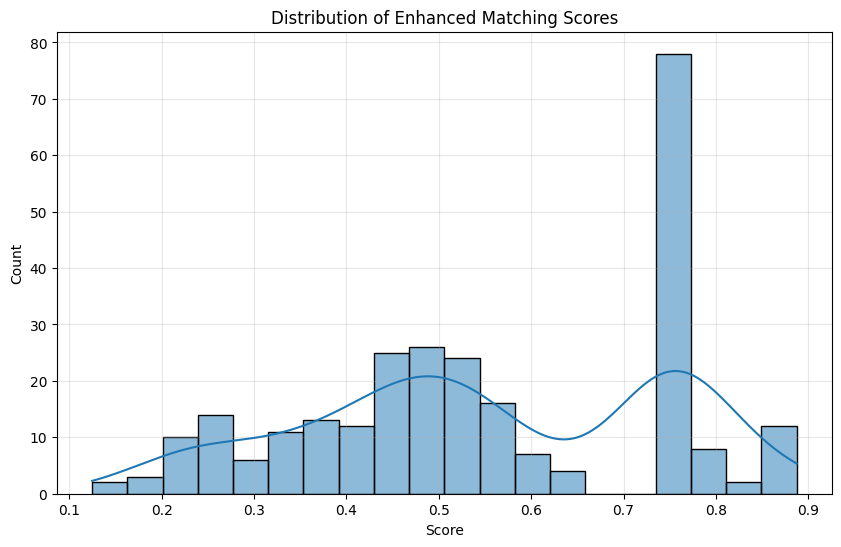

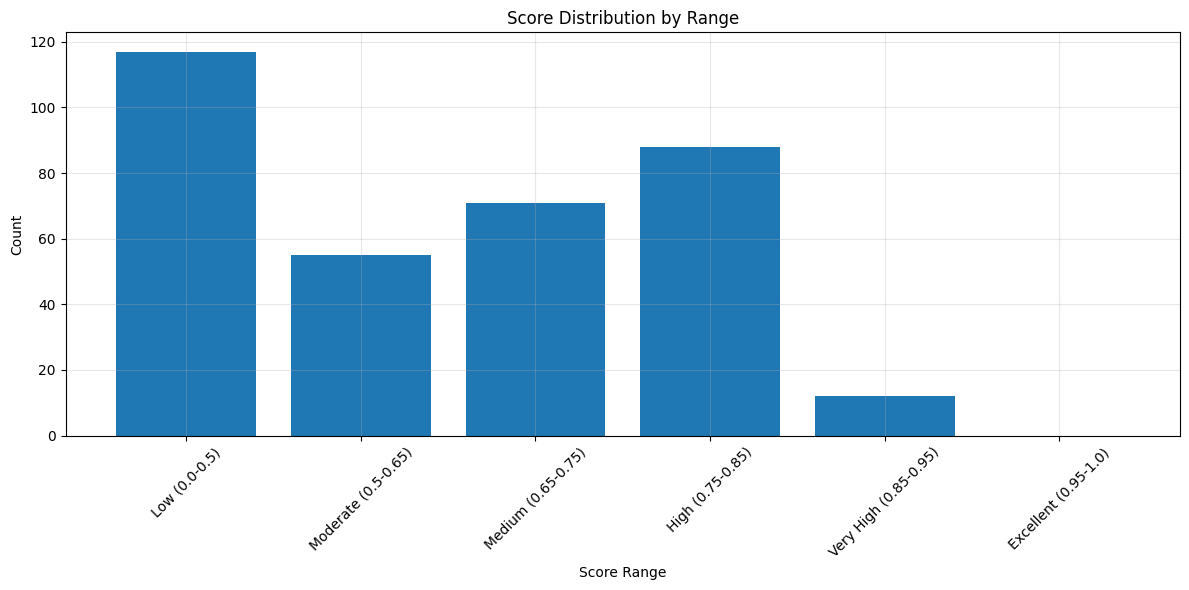

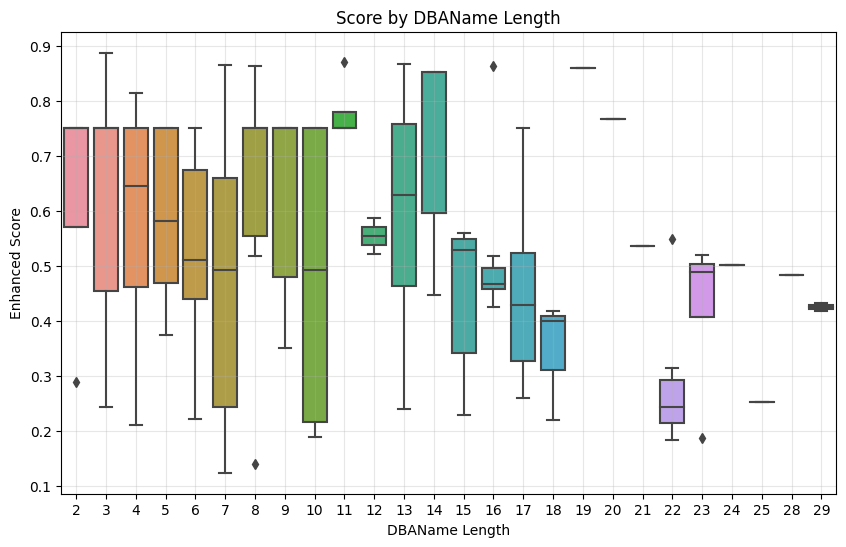

In [30]:
# Cell 7: Usage Examples and Main Execution

# This cell contains usage examples and demonstrations
merchant_matcher = None
DBA_Merchant_Category = None
RawTransaction_Merchant_Category = None

# Define thresholds for categorization
thresholds = {
    'Exact Match': 0.95,
    'Strong Match': 0.85,
    'Probable Match': 0.75,
    'Possible Match': 0.65,
    'Weak Match': 0.50,
    'No Match': 0.0
}

def main():
    """
    Main function to run the optimized merchant matching pipeline with proper error handling.
    Uses real data files only, with no synthetic data generation.
    Includes comprehensive analysis with visualizations.
    """
    start_time = time.time()
    
    # Dictionary to store all results
    results = {
        'results_df': None,
        'analysis_results': None,
        'comprehensive_analysis': None
    }
    
    print("\n" + "=" * 80)
    print("Enhanced Merchant Name Matching - Optimized Pipeline".center(80))
    print("=" * 80 + "\n")


    
    try:
        # Check for input file
        input_file = "Acronym_extramcc.xlsx"
        output_file = "Merchant_Matching_Results.xlsx"
        #If you ever need to change the file paths based on user input or configuration,
        #having them defined in main() makes this easier
        
        # Step 1: Initialize optimized matcher
        print("\nStep 1: Initializing optimized matcher...")
        bert_embedder = EnhancedBERTEmbedder(model_name='sentence-transformers/all-mpnet-base-v2')
        
        # Use the OptimizedMerchantMatcher instead of EnhancedMerchantMatcherWithSimilarity
        global merchant_matcher  # Make it available to run_merchant_pipeline
        merchant_matcher = OptimizedMerchantMatcher(bert_embedder=bert_embedder)
        
        print(f"Optimized merchant matcher initialized successfully with caching and grouped algorithms!")
        
        # Step 2-5: Run the merchant pipeline 
        print("\nStep 2-5: Running merchant pipeline...")
        results_df = run_merchant_pipeline(input_file, output_file)
        results['results_df'] = results_df
        
        
        
        # Step 7: Highlight visualization locations
        print("\nVisualizations generated:")
        print("  - Score distribution: analysis_output/score_distribution.png")
        print("  - Category distribution: analysis_output/category_distribution.png") 
        print("  - Score by length: analysis_output/score_by_length.png")
    
    except Exception as e:
        print(f"Error in merchant matching pipeline: {e}")
        import traceback
        traceback.print_exc()
    
    # Calculate total execution time
    total_time = time.time() - start_time
    print(f"\nMerchant matching pipeline completed in {total_time:.2f} seconds")
    
    return results

# Add the following at the end of the script to execute when run directly
if __name__ == "__main__":
    main()